In [1]:
import sys 
import cellphonedb
import scanpy as sc

import pandas as pd
import glob
import os

import numpy as np
import seaborn as sns 

import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

print(sys.version)

3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) 
[GCC 12.3.0]


## Prepare CellPhoneDB databases

In [2]:
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

In [3]:
# -- Version of the databse
cpdb_version = 'v5.0.0'

# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('/node200data/18parkky/datasets/reference/z_program_references/cellphoneDB/db', cpdb_version)

from cellphonedb.utils import db_utils

# db_utils.download_database(cpdb_target_dir, cpdb_version)

In [4]:
dict_PatientID_to_MSI_class = {'SC044': 'MSI-H',
                                'CRC2783': 'MSI-I',
                                'SC035': 'MSI-I',
                                'CRC2817': 'MSI-L',

                                'P04': 'MSI-H',
                                'P21': 'MSI-H',
                                'P23': 'MSI-H',
                                
                                'P15': 'MSI-I',
                                'P19': 'MSI-I',
                                'P20': 'MSI-I',
                                'P22': 'MSI-I',
                                'P26': 'MSI-I',
                                
                                'P17': 'MSI-L',
                                'P18': 'MSI-L'}

In [5]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.AuthorAnnot.MSI_score_labeled.h5ad')
adata.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PatientID] for PatientID in adata.obs['PatientID'] ]

/home/18parkky/anaconda3-2021.11/envs/cpdb/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/18parkky/anaconda3-2021.11/envs/cpdb/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


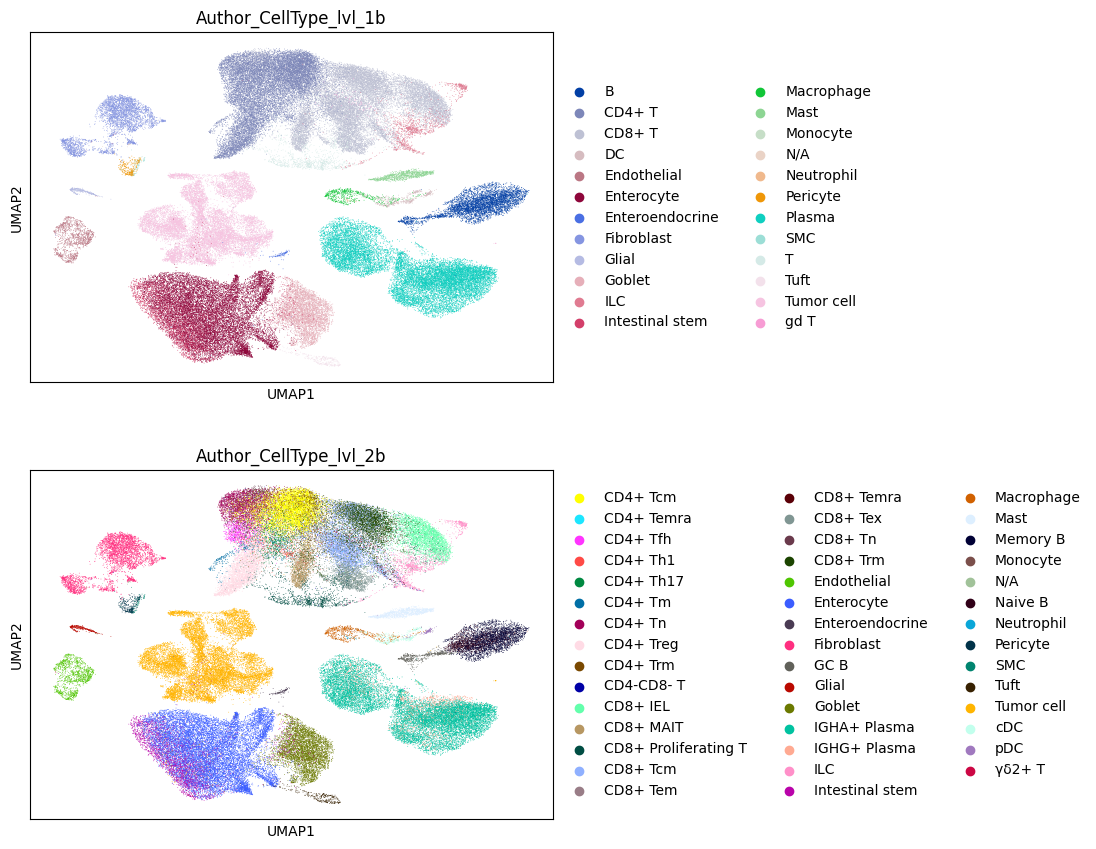

In [32]:
sc.pl.umap(adata, color=['Author_CellType_lvl_1b', 'Author_CellType_lvl_2b'], ncols=1,)

In [6]:
# adata_tumor = adata[(adata.obs['BiopsySite']=='Tumor') & 
#                     ~(adata.obs['Author_CellType_lvl_1b'].isin(['Enterocyte', 'Goblet', 'Intestinal stem', 'Tuft']))].copy()

adata_tumor = adata[(adata.obs['BiopsySite']=='Tumor')].copy()

## Cellphone DB - Method 2 - lvl 1b - No TF

In [7]:
DIR_workspace = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b'
if os.path.exists(DIR_workspace)==False: os.mkdir(DIR_workspace)

cpdb_file_path      = f'{cpdb_target_dir}/cellphonedb.zip'
meta_file_path      = f'{DIR_workspace}/metadata.tsv'                   # path to the meta file linking cell barcodes to cluster labels.
counts_file_path    = f'{DIR_workspace}/normalised_log_counts.h5ad'     # paths to normalized counts file
microenvs_file_path = f'{DIR_workspace}/microenvironment.tsv'           # path to microenvironment file that groups cell types/clusters by microenvironments. 
                                                                        # When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within the microenvironment.
out_path            = f'{DIR_workspace}'

### 1) metadata.tsv

In [205]:
for PatientID, edf in adata_tumor.obs.groupby('PatientID', observed=True):

    metadata = list()
    for tup in edf.itertuples():
        metadata.append( [tup.Index, tup.Author_CellType_lvl_1b] )
    metadata = pd.DataFrame(metadata, columns=['barcode_sample', 'cell_type'])
    
    DIR_out = f'{out_path}/{PatientID}'
    if os.path.exists(DIR_out)==False: os.mkdir( DIR_out )
    PATH_metadata = f'{DIR_out}/metadata.{PatientID}.tsv'
    
    metadata.to_csv(PATH_metadata, sep='\t', index=False)

### 2) normalised_log_counts.h5ad

In [206]:
for PatientID in set(adata_tumor.obs['PatientID']):

    adata_tumor_cpdb = adata_tumor[adata_tumor.obs['PatientID']==PatientID].raw.to_adata()
    sc.pp.normalize_total(adata_tumor_cpdb)
    sc.pp.log1p(adata_tumor_cpdb)
    
    DIR_out = f'{out_path}/{PatientID}'
    PATH_cpdb_counts = f'{DIR_out}/normalised_log_counts.{PatientID}.h5ad'
    adata_tumor_cpdb.write(PATH_cpdb_counts)

### Run CellphoneDB

In [207]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

for PatientID in set(adata_tumor.obs['PatientID']):
    print(PatientID, flush=True)
    
    PATH_cpdb_counts = f'{out_path}/{PatientID}/normalised_log_counts.{PatientID}.h5ad'
    PATH_metadata = f'{out_path}/{PatientID}/metadata.{PatientID}.tsv'

    cpdb_results = cpdb_statistical_analysis_method.call(
        cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
        meta_file_path = PATH_metadata,                 # mandatory: tsv file defining barcodes to cell label.
        counts_file_path = PATH_cpdb_counts,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
        counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
        # active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
        # microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
        score_interactions = True,                       # optional: whether to score interactions or not. 
        iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
        threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
        threads = 36,                                    # number of threads to use in the analysis.
        debug_seed = 42,                                 # debug randome seed. To disable >=0.
        result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
        pvalue = 0.05,                                   # P-value threshold to employ for significance.
        subsampling = False,                             # To enable subsampling the data (geometri sketching).
        subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
        subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
        subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
        separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
        debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
        output_path = f'{out_path}/{PatientID}',         # Path to save results.
        output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
        )

P17
Reading user files...
The following user files were loaded successfully:
/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P17/normalised_log_counts.P17.h5ad
/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P17/metadata.P17.tsv
[ ][CORE][17/03/25-23:04:51][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:36 Precision:3
[ ][CORE][17/03/25-23:04:51][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][17/03/25-23:04:52][INFO] Running Real Analysis
[ ][CORE][17/03/25-23:04:52][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:22<00:00, 44.08it/s]


[ ][CORE][17/03/25-23:05:19][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:05:20][INFO] Building results
[ ][CORE][17/03/25-23:05:20][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 17/17 [00:00<00:00, 192.34it/s]

[ ][CORE][17/03/25-23:05:20][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 17/17 [00:00<00:00, 530.24it/s]


[ ][CORE][17/03/25-23:05:21][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 289/289 [00:12<00:00, 22.52it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P17/statistical_analysis_deconvoluted_03_17_2025_230539.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P17/statistical_analysis_deconvoluted_percents_03_17_2025_230539.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P17/statistical_analysis_means_03_17_2025_230539.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P17/statistical_analysis_pvalues_03_17_2025_230539.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P17/statistical_analysis_significant_means_03_17_2025_230539.txt
Saved 

100%|██████████| 1000/1000 [00:43<00:00, 23.25it/s]


[ ][CORE][17/03/25-23:06:29][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:06:29][INFO] Building results
[ ][CORE][17/03/25-23:06:30][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 17/17 [00:00<00:00, 142.26it/s]

[ ][CORE][17/03/25-23:06:30][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 17/17 [00:00<00:00, 446.35it/s]


[ ][CORE][17/03/25-23:06:30][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 289/289 [00:11<00:00, 24.28it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P26/statistical_analysis_deconvoluted_03_17_2025_230648.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P26/statistical_analysis_deconvoluted_percents_03_17_2025_230648.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P26/statistical_analysis_means_03_17_2025_230648.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P26/statistical_analysis_pvalues_03_17_2025_230648.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P26/statistical_analysis_significant_means_03_17_2025_230648.txt
Saved 

100%|██████████| 1000/1000 [00:28<00:00, 35.64it/s]


[ ][CORE][17/03/25-23:07:23][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:07:23][INFO] Building results
[ ][CORE][17/03/25-23:07:23][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 15/15 [00:00<00:00, 130.20it/s]

[ ][CORE][17/03/25-23:07:23][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 15/15 [00:00<00:00, 406.77it/s]


[ ][CORE][17/03/25-23:07:24][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 225/225 [00:10<00:00, 21.86it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P20/statistical_analysis_deconvoluted_03_17_2025_230740.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P20/statistical_analysis_deconvoluted_percents_03_17_2025_230740.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P20/statistical_analysis_means_03_17_2025_230740.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P20/statistical_analysis_pvalues_03_17_2025_230740.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P20/statistical_analysis_significant_means_03_17_2025_230740.txt
Saved 

100%|██████████| 1000/1000 [00:37<00:00, 26.34it/s]


[ ][CORE][17/03/25-23:08:24][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:08:25][INFO] Building results
[ ][CORE][17/03/25-23:08:25][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 19/19 [00:00<00:00, 157.54it/s]

[ ][CORE][17/03/25-23:08:25][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 19/19 [00:00<00:00, 475.04it/s]


[ ][CORE][17/03/25-23:08:26][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 361/361 [00:16<00:00, 21.83it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P22/statistical_analysis_deconvoluted_03_17_2025_230849.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P22/statistical_analysis_deconvoluted_percents_03_17_2025_230849.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P22/statistical_analysis_means_03_17_2025_230849.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P22/statistical_analysis_pvalues_03_17_2025_230849.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P22/statistical_analysis_significant_means_03_17_2025_230849.txt
Saved 

100%|██████████| 1000/1000 [00:26<00:00, 37.19it/s]


[ ][CORE][17/03/25-23:09:22][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:09:22][INFO] Building results
[ ][CORE][17/03/25-23:09:23][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 18/18 [00:00<00:00, 148.38it/s]

[ ][CORE][17/03/25-23:09:23][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 18/18 [00:00<00:00, 487.89it/s]


[ ][CORE][17/03/25-23:09:23][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 324/324 [00:13<00:00, 24.45it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P21/statistical_analysis_deconvoluted_03_17_2025_230941.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P21/statistical_analysis_deconvoluted_percents_03_17_2025_230941.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P21/statistical_analysis_means_03_17_2025_230941.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P21/statistical_analysis_pvalues_03_17_2025_230941.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P21/statistical_analysis_significant_means_03_17_2025_230941.txt
Saved 

100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


[ ][CORE][17/03/25-23:10:08][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:10:09][INFO] Building results
[ ][CORE][17/03/25-23:10:09][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 17/17 [00:00<00:00, 167.05it/s]

[ ][CORE][17/03/25-23:10:10][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 17/17 [00:00<00:00, 462.37it/s]


[ ][CORE][17/03/25-23:10:10][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 289/289 [00:12<00:00, 23.36it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P23/statistical_analysis_deconvoluted_03_17_2025_231028.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P23/statistical_analysis_deconvoluted_percents_03_17_2025_231028.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P23/statistical_analysis_means_03_17_2025_231028.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P23/statistical_analysis_pvalues_03_17_2025_231028.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P23/statistical_analysis_significant_means_03_17_2025_231028.txt
Saved 

100%|██████████| 1000/1000 [00:19<00:00, 51.97it/s]


[ ][CORE][17/03/25-23:10:53][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:10:54][INFO] Building results
[ ][CORE][17/03/25-23:10:54][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 17/17 [00:00<00:00, 169.86it/s]

[ ][CORE][17/03/25-23:10:54][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 17/17 [00:00<00:00, 568.84it/s]


[ ][CORE][17/03/25-23:10:55][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 289/289 [00:12<00:00, 22.38it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P19/statistical_analysis_deconvoluted_03_17_2025_231113.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P19/statistical_analysis_deconvoluted_percents_03_17_2025_231113.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P19/statistical_analysis_means_03_17_2025_231113.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P19/statistical_analysis_pvalues_03_17_2025_231113.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P19/statistical_analysis_significant_means_03_17_2025_231113.txt
Saved 

100%|██████████| 1000/1000 [00:32<00:00, 30.52it/s]


[ ][CORE][17/03/25-23:11:52][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:11:53][INFO] Building results
[ ][CORE][17/03/25-23:11:53][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 19/19 [00:00<00:00, 112.75it/s]

[ ][CORE][17/03/25-23:11:53][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 19/19 [00:00<00:00, 387.72it/s]


[ ][CORE][17/03/25-23:11:54][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 361/361 [00:18<00:00, 19.05it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P15/statistical_analysis_deconvoluted_03_17_2025_231218.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P15/statistical_analysis_deconvoluted_percents_03_17_2025_231218.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P15/statistical_analysis_means_03_17_2025_231218.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P15/statistical_analysis_pvalues_03_17_2025_231218.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P15/statistical_analysis_significant_means_03_17_2025_231218.txt
Saved 

100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


[ ][CORE][17/03/25-23:12:43][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:12:44][INFO] Building results
[ ][CORE][17/03/25-23:12:44][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 17/17 [00:00<00:00, 155.67it/s]

[ ][CORE][17/03/25-23:12:44][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 17/17 [00:00<00:00, 498.51it/s]


[ ][CORE][17/03/25-23:12:45][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 289/289 [00:17<00:00, 16.77it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P18/statistical_analysis_deconvoluted_03_17_2025_231307.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P18/statistical_analysis_deconvoluted_percents_03_17_2025_231307.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P18/statistical_analysis_means_03_17_2025_231307.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P18/statistical_analysis_pvalues_03_17_2025_231307.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P18/statistical_analysis_significant_means_03_17_2025_231307.txt
Saved 

100%|██████████| 1000/1000 [00:34<00:00, 28.96it/s]


[ ][CORE][17/03/25-23:13:48][INFO] Building Pvalues result
[ ][CORE][17/03/25-23:13:49][INFO] Building results
[ ][CORE][17/03/25-23:13:49][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 17/17 [00:00<00:00, 125.95it/s]

[ ][CORE][17/03/25-23:13:49][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 17/17 [00:00<00:00, 419.79it/s]


[ ][CORE][17/03/25-23:13:50][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 289/289 [00:17<00:00, 16.49it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P04/statistical_analysis_deconvoluted_03_17_2025_231413.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P04/statistical_analysis_deconvoluted_percents_03_17_2025_231413.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P04/statistical_analysis_means_03_17_2025_231413.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P04/statistical_analysis_pvalues_03_17_2025_231413.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/P04/statistical_analysis_significant_means_03_17_2025_231413.txt
Saved 

### Explore results

In [213]:
import glob 

PatientID = 'P04'
PATH_significant_means  = glob.glob(f'/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/{PatientID}/statistical_analysis_significant_means*.txt')[0]
PATH_pvalues            = glob.glob(f'/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2_1b/{PatientID}/statistical_analysis_pvalues*.txt')[0] 

means   = pd.read_csv(PATH_significant_means, sep='\t')
pvalues = pd.read_csv(PATH_pvalues, sep='\t')

In [214]:
significant_ids = list()
pvalue_threshold = 0.05

for tup in pvalues.itertuples():
    list_pvalue = list(tup[14:])
    if min(list_pvalue) <= pvalue_threshold:
        significant_ids.append(tup.id_cp_interaction)

means_sig = means[(means['id_cp_interaction'].isin(significant_ids))].copy()

In [215]:
means_sig_tumorCd8 = list()
for tup in means_sig[['Tumor cell|CD8+ T', 'CD8+ T|Tumor cell']].itertuples():
    if min(tup[1:])>0:
        means_sig_tumorCd8.append(tup)

means_sig_tumorCd8 = pd.DataFrame(means_sig_tumorCd8)
means_sig_tumorCd8 = means_sig[means_sig.index.isin(means_sig_tumorCd8['Index'])]
means_sig_tumorCd8[means_sig_tumorCd8['interacting_pair']=='CEACAM5_CD8A'][['Tumor cell|CD8+ T', 'CD8+ T|Tumor cell']]

,Tumor cell|CD8+ T,CD8+ T|Tumor cell
315,0.712,NaN


In [216]:
cytotoxic_receptors = ['HAVCR2', 'LAG3', 'PDCD1', 'KLRK1', 'HLA-A', 'HLA-B', 'HLA-C', 'B2M', 'CD8A', 'CD69', 'TNFRSF9', 'FASLG']
means_sig[(means_sig['gene_a'].isin(cytotoxic_receptors)) | (means_sig['gene_b'].isin(cytotoxic_receptors))][['gene_a', 'gene_b', 'Tumor cell|CD8+ T', 'CD8+ T|Tumor cell']].sort_values('Tumor cell|CD8+ T')

,gene_a,gene_b,Tumor cell|CD8+ T,CD8+ T|Tumor cell
732,LGALS9,HAVCR2,0.185,NaN
388,TNFSF9,TNFRSF9,0.258,NaN
315,CEACAM5,CD8A,0.712,NaN
241,CD274,PDCD1,NaN,NaN
334,HLA-A,KIR3DL1,NaN,NaN
371,PDCD1LG2,PDCD1,NaN,NaN
398,HLA-B,KIR3DL2,NaN,NaN
415,HLA-C,KIR2DL1,NaN,NaN
476,FASLG,TNFRSF6B,NaN,NaN
567,FASLG,FAS,NaN,NaN


In [197]:
cytotoxic_receptors = ['HAVCR2', 'LAG3', 'PDCD1', 'KLRK1', 'HLA-A', 'HLA-B', 'HLA-C', 'B2M', 'CD8A', 'CD69', 'TNFRSF9', 'FASLG']
means_sig[(means_sig['gene_a'].isin(cytotoxic_receptors)) | (means_sig['gene_b'].isin(cytotoxic_receptors))][['gene_a', 'gene_b', 'Tumor cell|CD8+ T', 'CD8+ T|Tumor cell']].sort_values('Tumor cell|CD8+ T')

,gene_a,gene_b,Tumor cell|CD8+ T,CD8+ T|Tumor cell
737,LGALS9,HAVCR2,0.185,NaN
401,TNFSF9,TNFRSF9,0.258,NaN
250,CEACAM5,CD8A,0.712,NaN
286,CD274,PDCD1,NaN,NaN
322,HLA-A,KIR3DL1,NaN,NaN
366,PDCD1LG2,PDCD1,NaN,NaN
376,HLA-B,KIR3DL2,NaN,NaN
454,HLA-C,KIR2DL1,NaN,NaN
467,FASLG,TNFRSF6B,NaN,NaN
574,FASLG,FAS,NaN,NaN


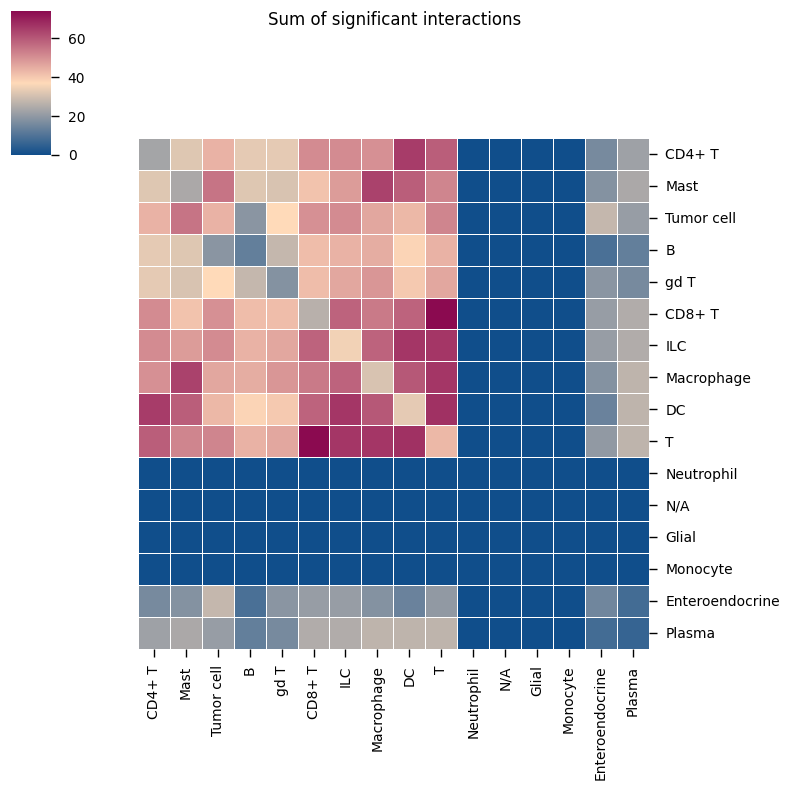

In [217]:
kpy.plot_cpdb_heatmap(pvals = pvalues,
                      cell_types=[ct for ct in set(adata_tumor.obs['Author_CellType_lvl_1b']) if ct not in ['SMC', 'Fibroblast', 'Pericyte', 'Endothelial']],
                      degs_analysis = False,
                      figsize = (8, 8),
                      title = "Sum of significant interactions", 
                      # **{'vmin':0, 'vmax':100, }
                      )

## Cellphone DB - Method 2 - lvl 2b - No TF

### Prepare input file for each MSI_class

In [9]:
DIR_workspace = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2'
if os.path.exists(DIR_workspace)==False: os.mkdir(DIR_workspace)

cpdb_file_path      = f'{cpdb_target_dir}/cellphonedb.zip'
meta_file_path      = f'{DIR_workspace}/metadata.tsv'                   # path to the meta file linking cell barcodes to cluster labels.
counts_file_path    = f'{DIR_workspace}/normalised_log_counts.h5ad'     # paths to normalized counts file
microenvs_file_path = f'{DIR_workspace}/microenvironment.tsv'           # path to microenvironment file that groups cell types/clusters by microenvironments. 
                                                                        # When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within the microenvironment.
out_path            = f'{DIR_workspace}'

#### 1) metadata.tsv

In [10]:
for PatientID, edf in adata_tumor.obs.groupby('PatientID', observed=True):

    metadata = list()
    for tup in edf.itertuples():
        metadata.append( [tup.Index, tup.Author_CellType_lvl_2b] )
    metadata = pd.DataFrame(metadata, columns=['barcode_sample', 'cell_type'])
    
    DIR_out = f'{out_path}/{PatientID}'
    if os.path.exists(DIR_out)==False: os.mkdir( DIR_out )
    PATH_metadata = f'{DIR_out}/metadata.{PatientID}.tsv'
    
    metadata.to_csv(PATH_metadata, sep='\t', index=False)

#### 2) normalised_log_counts.h5ad

In [11]:
for PatientID in set(adata_tumor.obs['PatientID']):

    adata_tumor_cpdb = adata_tumor[adata_tumor.obs['PatientID']==PatientID].raw.to_adata()
    sc.pp.normalize_total(adata_tumor_cpdb)
    sc.pp.log1p(adata_tumor_cpdb)
    
    DIR_out = f'{out_path}/{PatientID}'
    PATH_cpdb_counts = f'{DIR_out}/normalised_log_counts.{PatientID}.h5ad'
    adata_tumor_cpdb.write(PATH_cpdb_counts)

#### 3) microenvironment.tsv

### Run CellphoneDB

In [14]:
from cellphonedb.src.core.methods import cpdb_analysis_method
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

for PatientID in set(adata_tumor.obs['PatientID']):
    print(PatientID, flush=True)
    
    PATH_cpdb_counts = f'{out_path}/{PatientID}/normalised_log_counts.{PatientID}.h5ad'
    PATH_metadata = f'{out_path}/{PatientID}/metadata.{PatientID}.tsv'

    cpdb_results = cpdb_statistical_analysis_method.call(
        cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
        meta_file_path = PATH_metadata,                 # mandatory: tsv file defining barcodes to cell label.
        counts_file_path = PATH_cpdb_counts,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
        counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
        # active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
        # microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
        score_interactions = True,                       # optional: whether to score interactions or not. 
        iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
        threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
        threads = 36,                                    # number of threads to use in the analysis.
        debug_seed = 42,                                 # debug randome seed. To disable >=0.
        result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
        pvalue = 0.05,                                   # P-value threshold to employ for significance.
        subsampling = False,                             # To enable subsampling the data (geometri sketching).
        subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
        subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
        subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
        separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
        debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
        output_path = f'{out_path}/{PatientID}',         # Path to save results.
        output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
        )

    # cpdb_results = cpdb_analysis_method.call(
    #     cpdb_file_path = cpdb_file_path,           # mandatory: CellphoneDB database zip file.
    #     meta_file_path = PATH_metadata,            # mandatory: tsv file defining barcodes to cell label.
    #     counts_file_path = PATH_cpdb_counts,       # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    #     counts_data = 'hgnc_symbol',               # defines the gene annotation in counts matrix.
    #     score_interactions = True,                 # optional: whether to score interactions or not. 
    #     output_path = f'{out_path}/{PatientID}',   # Path to save results    microenvs_file_path = None,
    #     separator = '|',                           # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    #     threads = 36,                              # number of threads to use in the analysis.
    #     threshold = 0.1,                           # defines the min % of cells expressing a gene for this to be employed in the analysis.
    #     result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
    #     debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
    #     output_suffix = None                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
    # )

P15
Reading user files...
The following user files were loaded successfully:
/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P15/normalised_log_counts.P15.h5ad
/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P15/metadata.P15.tsv
[ ][CORE][17/03/25-20:38:21][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:36 Precision:3
[ ][CORE][17/03/25-20:38:21][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][17/03/25-20:38:22][INFO] Running Real Analysis
[ ][CORE][17/03/25-20:38:22][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


[ ][CORE][17/03/25-20:40:39][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:40:43][INFO] Building results
[ ][CORE][17/03/25-20:40:44][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 42/42 [00:00<00:00, 158.37it/s]

[ ][CORE][17/03/25-20:40:44][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 42/42 [00:00<00:00, 518.84it/s]


[ ][CORE][17/03/25-20:40:45][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1764/1764 [01:20<00:00, 21.88it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P15/statistical_analysis_deconvoluted_03_17_2025_204213.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P15/statistical_analysis_deconvoluted_percents_03_17_2025_204213.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P15/statistical_analysis_means_03_17_2025_204213.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P15/statistical_analysis_pvalues_03_17_2025_204213.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P15/statistical_analysis_significant_means_03_17_2025_204213.txt
Saved interaction_sco

100%|██████████| 1000/1000 [00:49<00:00, 20.03it/s]


[ ][CORE][17/03/25-20:43:16][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:43:19][INFO] Building results
[ ][CORE][17/03/25-20:43:19][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 38/38 [00:00<00:00, 179.23it/s]

[ ][CORE][17/03/25-20:43:20][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 38/38 [00:00<00:00, 598.78it/s]


[ ][CORE][17/03/25-20:43:20][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1444/1444 [00:58<00:00, 24.51it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P20/statistical_analysis_deconvoluted_03_17_2025_204427.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P20/statistical_analysis_deconvoluted_percents_03_17_2025_204427.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P20/statistical_analysis_means_03_17_2025_204427.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P20/statistical_analysis_pvalues_03_17_2025_204427.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P20/statistical_analysis_significant_means_03_17_2025_204427.txt
Saved interaction_sco

100%|██████████| 1000/1000 [01:08<00:00, 14.65it/s]


[ ][CORE][17/03/25-20:45:45][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:45:50][INFO] Building results
[ ][CORE][17/03/25-20:45:50][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 41/41 [00:00<00:00, 227.44it/s]

[ ][CORE][17/03/25-20:45:50][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 41/41 [00:00<00:00, 654.53it/s]


[ ][CORE][17/03/25-20:45:51][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1681/1681 [01:06<00:00, 25.41it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P21/statistical_analysis_deconvoluted_03_17_2025_204705.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P21/statistical_analysis_deconvoluted_percents_03_17_2025_204705.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P21/statistical_analysis_means_03_17_2025_204705.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P21/statistical_analysis_pvalues_03_17_2025_204705.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P21/statistical_analysis_significant_means_03_17_2025_204705.txt
Saved interaction_sco

100%|██████████| 1000/1000 [00:47<00:00, 21.04it/s]


[ ][CORE][17/03/25-20:48:04][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:48:08][INFO] Building results
[ ][CORE][17/03/25-20:48:08][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 39/39 [00:00<00:00, 196.05it/s]

[ ][CORE][17/03/25-20:48:09][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 39/39 [00:00<00:00, 558.48it/s]


[ ][CORE][17/03/25-20:48:09][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1521/1521 [01:05<00:00, 23.24it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P26/statistical_analysis_deconvoluted_03_17_2025_204922.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P26/statistical_analysis_deconvoluted_percents_03_17_2025_204922.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P26/statistical_analysis_means_03_17_2025_204922.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P26/statistical_analysis_pvalues_03_17_2025_204922.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P26/statistical_analysis_significant_means_03_17_2025_204922.txt
Saved interaction_sco

100%|██████████| 1000/1000 [00:48<00:00, 20.63it/s]


[ ][CORE][17/03/25-20:50:23][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:50:28][INFO] Building results
[ ][CORE][17/03/25-20:50:28][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 39/39 [00:00<00:00, 188.13it/s]

[ ][CORE][17/03/25-20:50:29][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 39/39 [00:00<00:00, 548.15it/s]


[ ][CORE][17/03/25-20:50:29][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1521/1521 [01:08<00:00, 22.18it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P23/statistical_analysis_deconvoluted_03_17_2025_205146.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P23/statistical_analysis_deconvoluted_percents_03_17_2025_205146.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P23/statistical_analysis_means_03_17_2025_205146.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P23/statistical_analysis_pvalues_03_17_2025_205146.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P23/statistical_analysis_significant_means_03_17_2025_205146.txt
Saved interaction_sco

100%|██████████| 1000/1000 [00:57<00:00, 17.53it/s]


[ ][CORE][17/03/25-20:52:55][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:52:59][INFO] Building results
[ ][CORE][17/03/25-20:52:59][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 39/39 [00:00<00:00, 160.49it/s]

[ ][CORE][17/03/25-20:53:00][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 39/39 [00:00<00:00, 528.96it/s]


[ ][CORE][17/03/25-20:53:01][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1521/1521 [01:03<00:00, 23.79it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P04/statistical_analysis_deconvoluted_03_17_2025_205413.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P04/statistical_analysis_deconvoluted_percents_03_17_2025_205413.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P04/statistical_analysis_means_03_17_2025_205413.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P04/statistical_analysis_pvalues_03_17_2025_205413.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P04/statistical_analysis_significant_means_03_17_2025_205413.txt
Saved interaction_sco

100%|██████████| 1000/1000 [00:55<00:00, 18.14it/s]


[ ][CORE][17/03/25-20:55:20][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:55:26][INFO] Building results
[ ][CORE][17/03/25-20:55:26][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 41/41 [00:00<00:00, 161.53it/s]

[ ][CORE][17/03/25-20:55:26][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 41/41 [00:00<00:00, 528.09it/s]


[ ][CORE][17/03/25-20:55:27][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1681/1681 [01:16<00:00, 21.88it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P22/statistical_analysis_deconvoluted_03_17_2025_205653.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P22/statistical_analysis_deconvoluted_percents_03_17_2025_205653.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P22/statistical_analysis_means_03_17_2025_205653.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P22/statistical_analysis_pvalues_03_17_2025_205653.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P22/statistical_analysis_significant_means_03_17_2025_205653.txt
Saved interaction_sco

100%|██████████| 1000/1000 [00:25<00:00, 39.86it/s]


[ ][CORE][17/03/25-20:57:31][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:57:33][INFO] Building results
[ ][CORE][17/03/25-20:57:34][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 34/34 [00:00<00:00, 226.76it/s]

[ ][CORE][17/03/25-20:57:34][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 34/34 [00:00<00:00, 622.62it/s]


[ ][CORE][17/03/25-20:57:35][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1156/1156 [00:48<00:00, 23.60it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P18/statistical_analysis_deconvoluted_03_17_2025_205830.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P18/statistical_analysis_deconvoluted_percents_03_17_2025_205830.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P18/statistical_analysis_means_03_17_2025_205830.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P18/statistical_analysis_pvalues_03_17_2025_205830.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P18/statistical_analysis_significant_means_03_17_2025_205830.txt
Saved interaction_sco

100%|██████████| 1000/1000 [00:32<00:00, 30.56it/s]


[ ][CORE][17/03/25-20:59:12][INFO] Building Pvalues result
[ ][CORE][17/03/25-20:59:15][INFO] Building results
[ ][CORE][17/03/25-20:59:15][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 35/35 [00:00<00:00, 222.73it/s]

[ ][CORE][17/03/25-20:59:15][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 35/35 [00:00<00:00, 642.30it/s]


[ ][CORE][17/03/25-20:59:16][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1225/1225 [00:50<00:00, 24.49it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P19/statistical_analysis_deconvoluted_03_17_2025_210013.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P19/statistical_analysis_deconvoluted_percents_03_17_2025_210013.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P19/statistical_analysis_means_03_17_2025_210013.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P19/statistical_analysis_pvalues_03_17_2025_210013.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P19/statistical_analysis_significant_means_03_17_2025_210013.txt
Saved interaction_sco

100%|██████████| 1000/1000 [00:44<00:00, 22.45it/s]


[ ][CORE][17/03/25-21:01:08][INFO] Building Pvalues result
[ ][CORE][17/03/25-21:01:11][INFO] Building results
[ ][CORE][17/03/25-21:01:12][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 37/37 [00:00<00:00, 226.76it/s]

[ ][CORE][17/03/25-21:01:12][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 37/37 [00:00<00:00, 665.23it/s]


[ ][CORE][17/03/25-21:01:13][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 1369/1369 [01:02<00:00, 21.93it/s]


Saved deconvoluted to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P17/statistical_analysis_deconvoluted_03_17_2025_210223.txt
Saved deconvoluted_percents to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P17/statistical_analysis_deconvoluted_percents_03_17_2025_210223.txt
Saved means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P17/statistical_analysis_means_03_17_2025_210223.txt
Saved pvalues to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P17/statistical_analysis_pvalues_03_17_2025_210223.txt
Saved significant_means to /node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/P17/statistical_analysis_significant_means_03_17_2025_210223.txt
Saved interaction_sco

### Explore results

In [52]:
import glob 

PatientID = 'P18'
PATH_significant_means  = glob.glob(f'/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/{PatientID}/statistical_analysis_significant_means*.txt')[0]
PATH_pvalues            = glob.glob(f'/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/CellphoneDB/method2/{PatientID}/statistical_analysis_pvalues*.txt')[0] 

means   = pd.read_csv(PATH_significant_means, sep='\t')
pvalues = pd.read_csv(PATH_pvalues, sep='\t')

In [74]:
significant_ids = list()
pvalue_threshold = 0.05

for tup in pvalues.itertuples():
    list_pvalue = list(tup[14:])
    if min(list_pvalue) <= pvalue_threshold:
        significant_ids.append(tup.id_cp_interaction)

means_sig = means[(means['id_cp_interaction'].isin(significant_ids))].copy()
means_sig[['Tumor cell|SMC', 'Tumor cell|Pericyte', 'Tumor cell|Endothelial', 'Tumor cell|Fibroblast']].dropna()

,Tumor cell|SMC,Tumor cell|Pericyte,Tumor cell|Endothelial,Tumor cell|Fibroblast
373,0.266,0.406,0.761,0.695
425,0.526,0.833,0.308,0.714
450,0.365,0.321,0.199,0.229


In [78]:
means_sig[means_sig.index==450][['gene_a', 'gene_b']]

,gene_a,gene_b
450,SDC1,ADGRA2


In [88]:
order_e = list(set(adata.obs['Author_CellType_lvl_2b']))

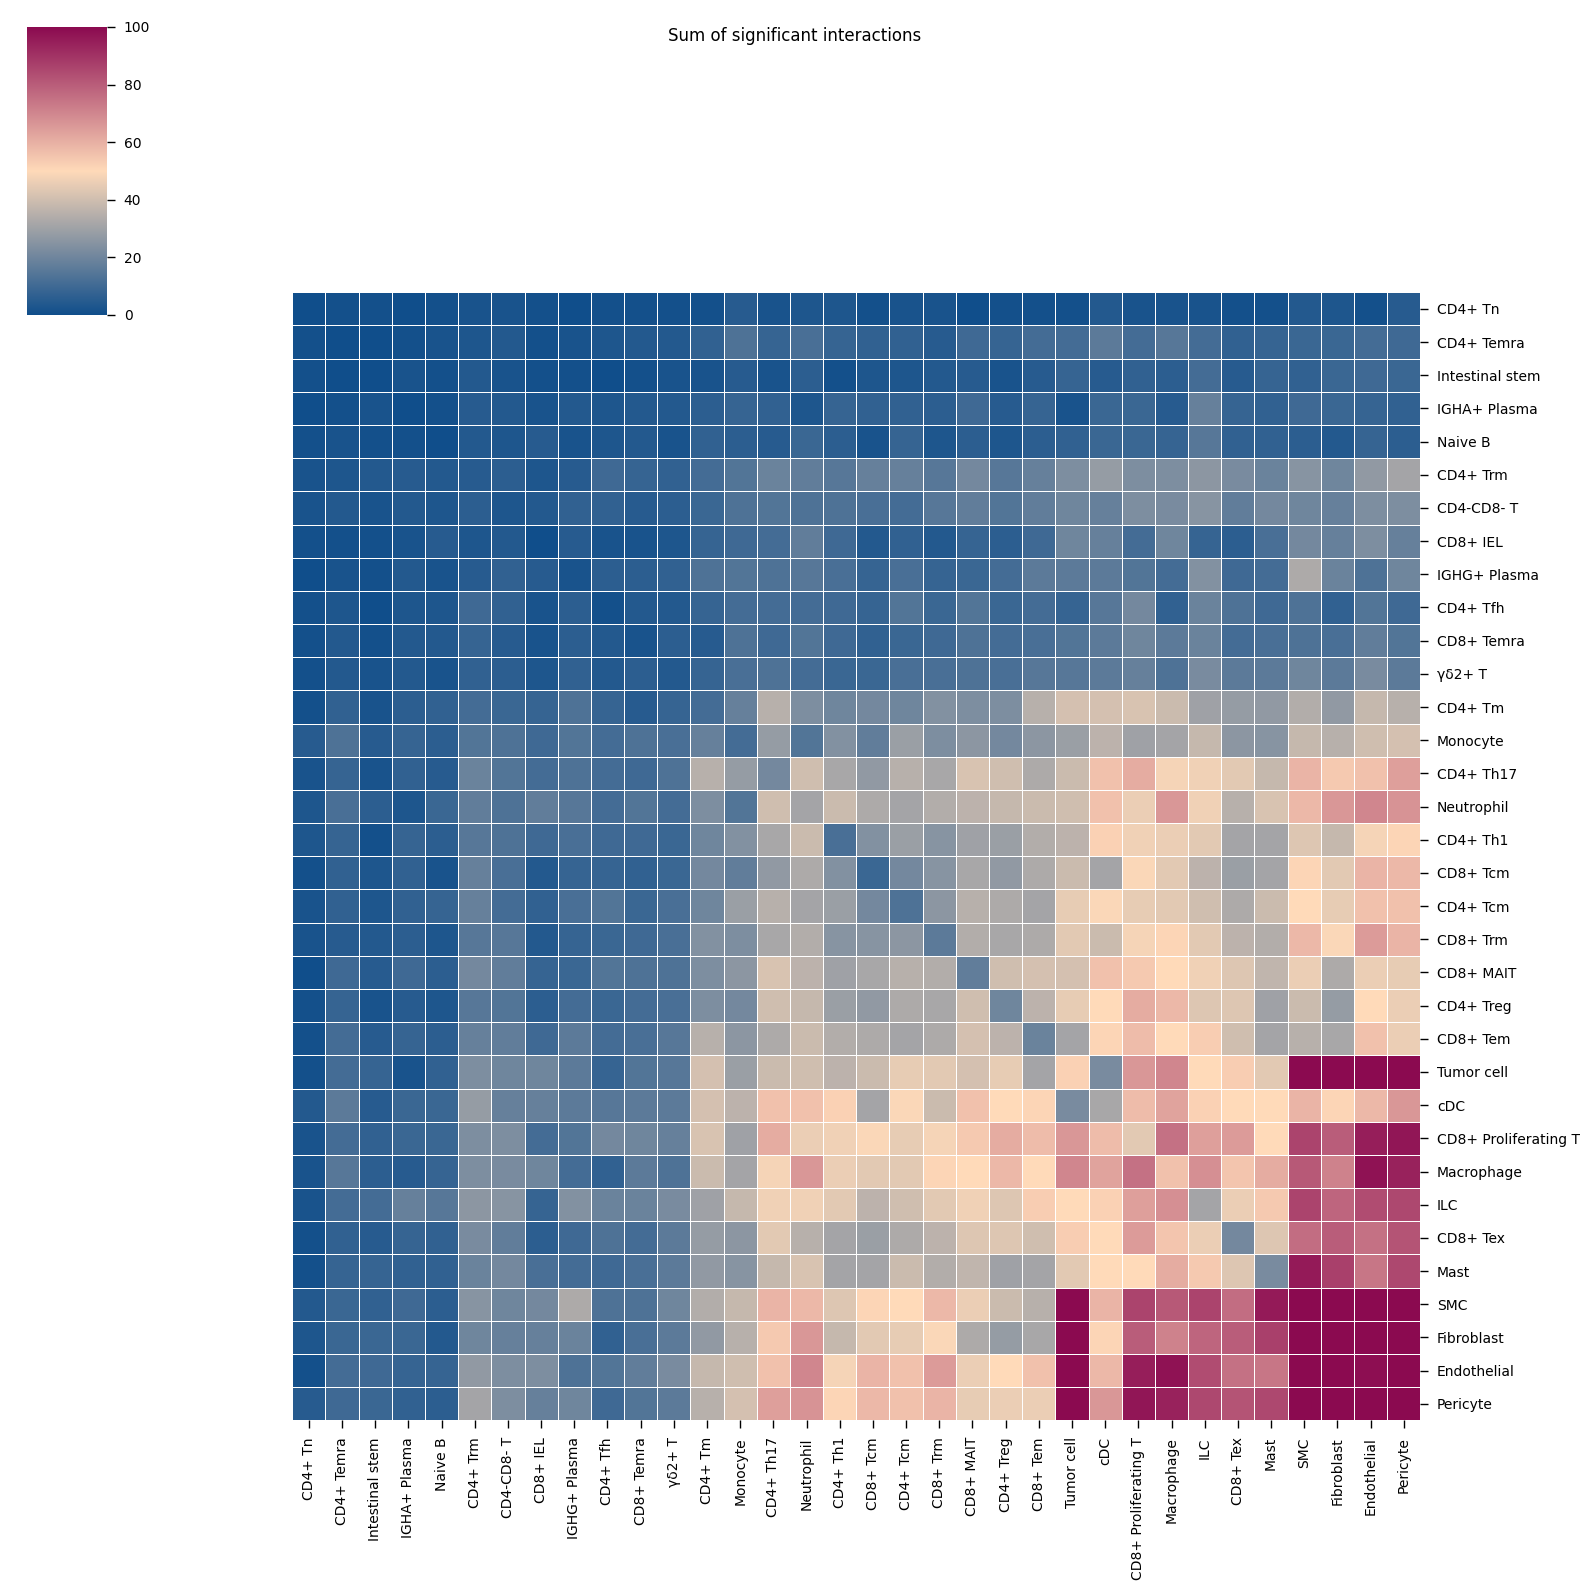

In [90]:
kpy.plot_cpdb_heatmap(pvals = pvalues,
                      degs_analysis = False,
                      figsize = (16, 16),
                      title = "Sum of significant interactions", 
                      **{'vmin':0, 'vmax':100, })

In [40]:
means_sig.sort_values('rank', ascending=False, inplace=True)
means_sig

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,γδ2+ T|Monocyte,γδ2+ T|Naive B,γδ2+ T|Neutrophil,γδ2+ T|Pericyte,γδ2+ T|Tuft,γδ2+ T|Tumor cell,γδ2+ T|cDC,γδ2+ T|nan,γδ2+ T|pDC,γδ2+ T|γδ2+ T
785,CPI-SS0E2453044,PPIA_BSG,simple:P62937,simple:P35613,PPIA,BSG,True,False,False,curated,...,NaN,NaN,NaN,1.141,NaN,1.102,NaN,1.182,NaN,NaN
784,CPI-SS0F16EAEBB,HLA-E_VSIR,simple:P13747,simple:Q9H7M9,HLA-E,VSIR,False,False,True,curated,...,1.523,1.2,1.612,1.206,NaN,NaN,1.268,1.304,1.203,1.222
783,CPI-SS0F7113A7D,SEMA4D_PTPRC,simple:Q92854,simple:P08575,SEMA4D,PTPRC,False,True,False,curated,...,NaN,NaN,0.870,NaN,NaN,NaN,NaN,NaN,NaN,1.151
782,CPI-SS080C81D37,APP_CD74,simple:P05067,simple:P04233,APP,CD74,False,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
781,CPI-SC09DC9200A,ICAM3_integrin_aLb2_complex,simple:P32942,complex:integrin_aLb2_complex,ICAM3,NaN,False,False,False,curated,...,0.659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,CPI-CS09DCEBC2B,ProstaglandinE2_byPTGES_PTGER1,complex:ProstaglandinE2_byPTGES,simple:P34995,NaN,PTGER1,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,CPI-SS09A6C048C,CLSTN2_NRXN1,simple:Q9H4D0,simple:Q9ULB1,CLSTN2,NRXN1,False,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,CPI-SC02CD655EB,CALCB_RAMP1_complex,simple:P10092,complex:RAMP1_complex,CALCB,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,CPI-CS064B4FE21,Adenosine_byNT5E_and_SLC29A1_ADORA1,complex:Adenosine_byNT5E_and_SLC29A1,simple:P30542,NaN,ADORA1,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

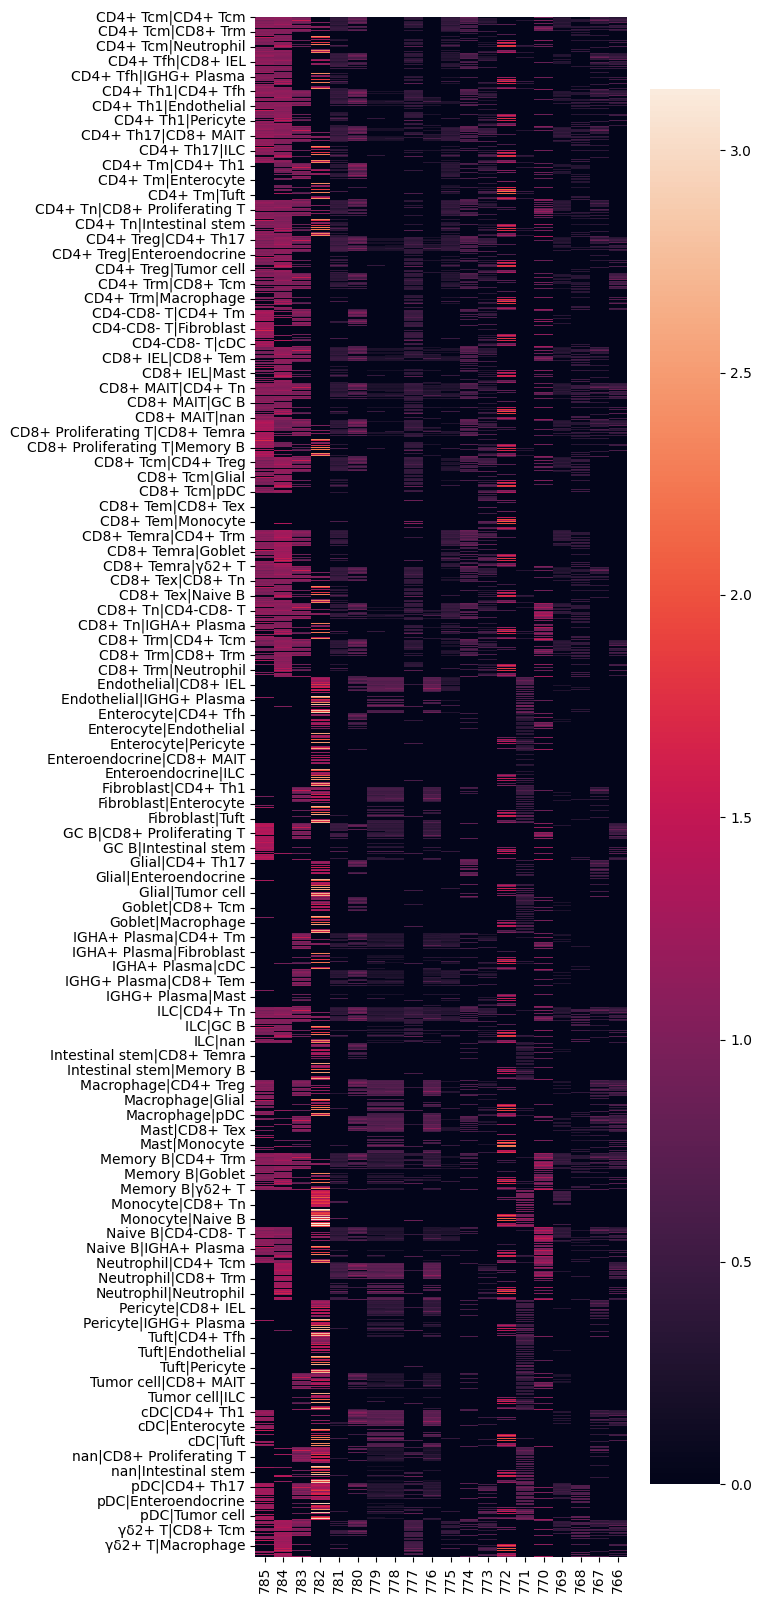

In [42]:
cell_pair_columns = list(means_sig.columns)[14:]

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 20))
sns.heatmap(means_sig.head(20)[cell_pair_columns].fillna(0).T)

In [12]:
means.sort_values('id_cp_interaction')

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,γδ2+ T|Monocyte,γδ2+ T|Naive B,γδ2+ T|Neutrophil,γδ2+ T|Pericyte,γδ2+ T|Tuft,γδ2+ T|Tumor cell,γδ2+ T|cDC,γδ2+ T|nan,γδ2+ T|pDC,γδ2+ T|γδ2+ T
1038,CPI-CC000118AA2,atRetinoicAcid_byALDH1A2_RAreceptor_RARG_RXRG,complex:atRetinoicAcid_byALDH1A2,complex:RAreceptor_RARG_RXRG,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,CPI-CC00045ECF5,Glycine_bySHMT2_and_SLC6A9_Glycine_a1b_complex,complex:Glycine_bySHMT2_and_SLC6A9,complex:Glycine_a1b_complex,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1100,CPI-CC0010C54C6,atRetinoicAcid_byALDH1A1_RAreceptor_RARA,complex:atRetinoicAcid_byALDH1A1,complex:RAreceptor_RARA,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,CPI-CC0021FE823,Activin_ligand_ab_ACVR_1C2A_receptor,complex:Activin_ligand_ab,complex:ACVR_1C2A_receptor,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1660,CPI-CC00289947C,GABA_byGAD1_and_SLC6A6_GABA-A_a6b3g2S_complex,complex:GABA_byGAD1_and_SLC6A6,complex:GABA-A_a6b3g2S_complex,NaN,NaN,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,CPI-SS0FEEB187C,PDGFB_PDGFRA,simple:P01127,simple:P16234,PDGFB,PDGFRA,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
916,CPI-SS0FF0C7449,HFE_TFRC,simple:Q30201,simple:P02786,HFE,TFRC,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,CPI-SS0FF2EEAE8,WNT5B_SFRP1,simple:Q9H1J7,simple:Q8N474,WNT5B,SFRP1,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928,CPI-SS0FF49C823,EFNA1_EPHA1,simple:P20827,simple:P21709,EFNA1,EPHA1,True,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
pvalues.sort_values('id_cp_interaction')

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,γδ2+ T|Monocyte,γδ2+ T|Naive B,γδ2+ T|Neutrophil,γδ2+ T|Pericyte,γδ2+ T|Tuft,γδ2+ T|Tumor cell,γδ2+ T|cDC,γδ2+ T|nan,γδ2+ T|pDC,γδ2+ T|γδ2+ T
1717,CPI-CC000118AA2,atRetinoicAcid_byALDH1A2_RAreceptor_RARG_RXRG,complex:atRetinoicAcid_byALDH1A2,complex:RAreceptor_RARG_RXRG,NaN,NaN,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1355,CPI-CC00045ECF5,Glycine_bySHMT2_and_SLC6A9_Glycine_a1b_complex,complex:Glycine_bySHMT2_and_SLC6A9,complex:Glycine_a1b_complex,NaN,NaN,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1701,CPI-CC0010C54C6,atRetinoicAcid_byALDH1A1_RAreceptor_RARA,complex:atRetinoicAcid_byALDH1A1,complex:RAreceptor_RARA,NaN,NaN,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1401,CPI-CC0021FE823,Activin_ligand_ab_ACVR_1C2A_receptor,complex:Activin_ligand_ab,complex:ACVR_1C2A_receptor,NaN,NaN,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1040,CPI-CC00289947C,GABA_byGAD1_and_SLC6A6_GABA-A_a6b3g2S_complex,complex:GABA_byGAD1_and_SLC6A6,complex:GABA-A_a6b3g2S_complex,NaN,NaN,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,CPI-SS0FEEB187C,PDGFB_PDGFRA,simple:P01127,simple:P16234,PDGFB,PDGFRA,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1875,CPI-SS0FF0C7449,HFE_TFRC,simple:Q30201,simple:P02786,HFE,TFRC,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2269,CPI-SS0FF2EEAE8,WNT5B_SFRP1,simple:Q9H1J7,simple:Q8N474,WNT5B,SFRP1,True,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
769,CPI-SS0FF49C823,EFNA1_EPHA1,simple:P20827,simple:P21709,EFNA1,EPHA1,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
n = 13
metacolumns = list()
cellpaircolumns = list()
for idx, column in enumerate(cpdb_results['means_result'].columns):
    if idx < 13:
        print(column)
        metacolumns.append( column )
    else:
        cellpaircolumns.append( column )

{'deconvoluted':              gene_name uniprot  is_complex protein_name  \
 multidata_id                                              
 1355           UBASH3B  Q8TF42        True  UBS3B_HUMAN   
 1355           UBASH3B  Q8TF42        True  UBS3B_HUMAN   
 1355           UBASH3B  Q8TF42        True  UBS3B_HUMAN   
 1356           SULT1A1  P50225        True  ST1A1_HUMAN   
 1356           SULT1A1  P50225        True  ST1A1_HUMAN   
 ...                ...     ...         ...          ...   
 1354              TLR8  Q9NR97       False   TLR8_HUMAN   
 363               CD44  P16070       False   CD44_HUMAN   
 1353           SIGLEC1  Q9BZZ2       False     SN_HUMAN   
 565                MPL  P40238       False   TPOR_HUMAN   
 368             PECAM1  P16284       False  PECA1_HUMAN   
 
                               complex_name id_cp_interaction     gene  \
 multidata_id                                                            
 1355          Dehydroepiandrosterone_bySTS   CPI-CS09

In [101]:
cpdb_results['interaction_scores'][metacolumns+['CD8+ Tem|Tumor cell']].sort_values('CD8+ Tem|Tumor cell', ascending=False,).head(10)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,CD8+ Tem|Tumor cell
2895,CPI-SS0E2453044,PPIA_BSG,simple:P62937,simple:P35613,PPIA,BSG,True,False,False,curated,False,Ligand-Receptor,NaN,24.408
563,CPI-SS02A53F29E,LRPAP1_SORT1,simple:P30533,simple:Q99523,LRPAP1,SORT1,False,False,True,curated,False,Ligand-Receptor,NaN,23.425
2867,CPI-SS03F821467,CD96_NECTIN1,simple:P40200,simple:Q15223,CD96,NECTIN1,True,True,True,curated,False,Receptor-Receptor,NaN,20.671
2890,CPI-SS09CEEE405,MPZL1_MPZL1,simple:O95297,simple:O95297,MPZL1,MPZL1,False,False,False,curated,False,Adhesion-Adhesion,NaN,18.400
2068,CPI-CS08E678B9D,ProstaglandinE2_byPTGES2_PTGER4,complex:ProstaglandinE2_byPTGES2,simple:P35408,NaN,PTGER4,True,False,True,curated,False,Ligand-Receptor,Signaling by Prostaglandin,9.318
2069,CPI-CS036B95798,ProstaglandinE2_byPTGES3_PTGER4,complex:ProstaglandinE2_byPTGES3,simple:P35408,NaN,PTGER4,True,False,True,curated,False,Ligand-Receptor,Signaling by Prostaglandin,3.677
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.000
1986,CPI-SS0674B0F46,SEMA3F_NRP2,simple:Q13275,simple:O60462,SEMA3F,NRP2,True,False,True,curated,False,Ligand-Receptor,Signaling by Semaphorin,0.000
1981,CPI-SS034083FFA,SEMA3A_NRP1,simple:Q14563,simple:O14786,SEMA3A,NRP1,True,False,True,curated,False,Ligand-Receptor,Signaling by Semaphorin,0.000
1982,CPI-SS043E22BF5,VEGFA_NRP1,simple:P15692,simple:O14786,VEGFA,NRP1,True,False,True,curated,False,Ligand-Receptor,Signaling by Vascular endothelial growth factor,0.000


In [61]:




for tup in cpdb_results['interaction_scores'].itertuples():
    scores = list(tup[14:])
    print(max(scores), min(scores), np.mean(scores))
    break 



100.0 0.0 1.2791787190082644


<Axes: xlabel='count', ylabel='classification'>

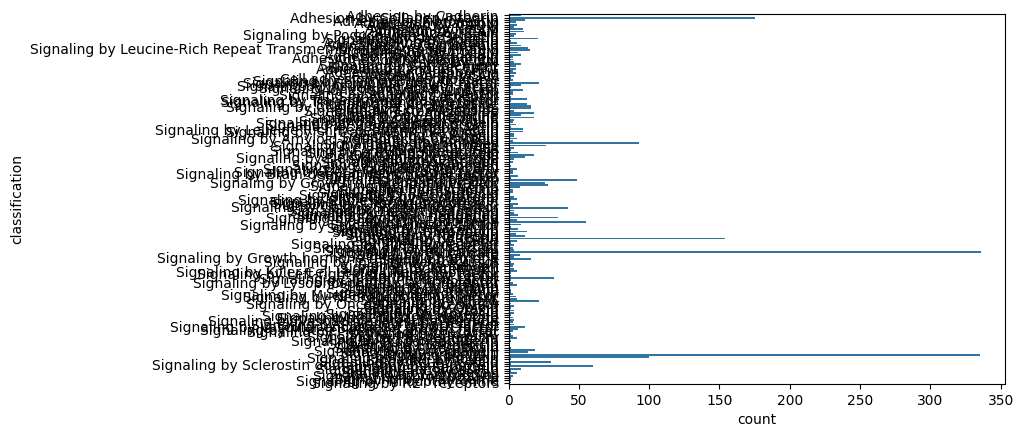

In [70]:

sns.countplot(data=cpdb_results['interaction_scores'][['classification']].dropna(), y='classification')

In [ ]:
cpdb_file_path = f'{cpdb_target_dir}/v5/cellphonedb.zip'

meta_file_path = 'data/metadata.tsv'                    # path to the meta file linking cell barcodes to cluster labels.
counts_file_path = 'data/normalised_log_counts.h5ad'    # paths to normalized counts file
degs_file_path = 'data/DEGs_inv_trophoblast.tsv'        # path to the DEG file indicating the differentially expressed genes in each cluster.

microenvs_file_path = 'data/microenvironment.tsv'       # path to microenvironment file that groups cell types/clusters by microenvironments. 
                                                        # When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within the microenvironment.
active_tf_path = 'data/active_TFs.tsv'                  # active transcription factors

out_path = 'results/method3_withScore'